Laboratorio 03: Modelo Integral de ML para Operaciones Petroleras
==================================================================

Objetivo: Combinar predicción y clasificación para crear un sistema integral
          de monitoreo y predicción para operaciones petroleras.

Tareas:
1. Integrar datos de múltiples fuentes
2. Crear pipeline de ML completo
3. Implementar predicción de producción Y detección de eventos
4. Generar dashboard de resultados
5. Crear sistema de recomendaciones automatizado

Tiempo estimado: 45 minutos


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    classification_report,
    confusion_matrix
)
import warnings

In [2]:
# ------------------------------------------------------------------
# Utilidades
# ------------------------------------------------------------------
def safe_to_datetime(s, fmt=None):
    """Convierte a datetime de manera segura (devuelve NaT si falla)."""
    if fmt:
        return pd.to_datetime(s, format=fmt, errors='coerce')
    return pd.to_datetime(s, errors='coerce')

def info_df(df, name):
    print(f"→ {name}: {df.shape[0]:,} filas × {df.shape[1]:,} columnas")
    print(df.head(2))
    print()

In [3]:
# TAREA 1: Integración de datos
# ==============================
print("\nTAREA 1: Integrar datos de múltiples fuentes")
print("-" * 40)

PATH_PROD     = '/workspaces/CursoPython-Basico-JuanDavid/Proyecto_Final/produccion_historica.csv'
PATH_EVENTOS  = '/workspaces/CursoPython-Basico-JuanDavid/Proyecto_Final/eventos_operacionales.csv'
PATH_PARAM    = '/workspaces/CursoPython-Basico-JuanDavid/Proyecto_Final/parametros_pozos.csv'
PATH_ANOMAL   = '/workspaces/CursoPython-Basico-JuanDavid/Proyecto_Final/anomalias_sensores.csv'  


# Cargar y preparar datasets
try:
    df_produccion = pd.read_csv(PATH_PROD)
    df_eventos = pd.read_csv(PATH_EVENTOS)
    df_parametros = pd.read_csv(PATH_PARAM)
    df_anomalias = pd.read_csv(PATH_ANOMAL)    
except FileNotFoundError as e:
    print("⚠️ No se encontraron uno o más archivos CSV con las rutas actuales.")
    print("   Ajusta manualmente las rutas según tu Codespace y vuelve a ejecutar.")
    raise

# Normalizar tipos de fecha
# produccion/parametros usan 'fecha' diaria; eventos 'fecha' con hora; anomalias 'timestamp'
df_produccion['fecha'] = safe_to_datetime(df_produccion['fecha'])
df_parametros['fecha'] = safe_to_datetime(df_parametros['fecha'])

# Homogeneizar columnas clave
for dfx in (df_produccion, df_parametros):
    dfx['well_id'] = dfx['well_id'].astype(str)

# Merge principal a nivel diario por well_id + fecha
df_integrado = (
    pd.merge(df_produccion, df_parametros, on=['fecha', 'well_id'], how='left', suffixes=('', '_param'))
)

print(f"Dataset integrado: {df_integrado.shape if df_integrado is not None else 'No creado'}")
info_df(df_integrado, "df_integrado (preview)")

# Crear features temporales
def crear_features_temporales(df):
    """
    Crea features basadas en tiempo y ventanas móviles por pozo.
    """
    df = df.copy()
    df['fecha'] = safe_to_datetime(df['fecha'])
    df = df.sort_values(['well_id', 'fecha'])

    # Componentes calendario
    df['dia_semana'] = df['fecha'].dt.dayofweek
    df['mes'] = df['fecha'].dt.month
    df['trimestre'] = df['fecha'].dt.quarter

    # Ventanas móviles por pozo
    df['prod_promedio_7d'] = (
        df.groupby('well_id')['produccion_oil_bbl']
          .transform(lambda s: s.rolling(window=7, min_periods=1).mean())
    )
    df['prod_std_7d'] = (
        df.groupby('well_id')['produccion_oil_bbl']
          .transform(lambda s: s.rolling(window=7, min_periods=1).std())
    )

    # Lags operacionales (útiles en series de tiempo)
    for lag in [1, 3, 7]:
        df[f'oil_lag_{lag}'] = (
            df.groupby('well_id')['produccion_oil_bbl'].shift(lag)
        )

    return df

# Aplicar ingeniería de features temporal
df_procesado = crear_features_temporales(df_integrado) if df_integrado is not None else None


TAREA 1: Integrar datos de múltiples fuentes
----------------------------------------
Dataset integrado: (500, 18)
→ df_integrado (preview): 500 filas × 18 columnas
       fecha   well_id  presion_boca_psi  temperatura_f  dias_operacion  \
0 2024-04-14  POZO-003            1488.9          196.1               1   
1 2024-04-15  POZO-003            1410.7          158.2               2   

   choke_size  produccion_oil_bbl  produccion_gas_mcf  produccion_agua_bbl  \
0          28              1447.5               728.5                424.9   
1          36              1536.7               805.5                473.3   

   presion_fondo_psi  presion_cabeza_psi  temperatura_fondo_f  \
0                NaN                 NaN                  NaN   
1            2159.68             1309.65               193.12   

   flujo_total_bpd  corte_agua_pct  gor_scf_bbl  indice_productividad  \
0              NaN             NaN          NaN                   NaN   
1          1331.48           25

In [4]:
# TAREA 2: Pipeline de preparación
# =================================
print("\nTAREA 2: Crear pipeline de ML")
print("-" * 40)

# Definir features para cada modelo
# (Regresión de producción diaria)
features_produccion = [
    'presion_boca_psi', 'temperatura_f', 'dias_operacion', 'choke_size',
    'prod_promedio_7d', 'mes', 'trimestre', 'prod_std_7d',
    'presion_cabeza_psi', 'indice_productividad', 'corte_agua_pct',
    'gor_scf_bbl', 'dias_desde_mantenimiento', 'horas_operacion_continua',
    'oil_lag_1', 'oil_lag_3', 'oil_lag_7'
]

# (Clasificación de anomalías de sensores)
# Usaremos el dataset de anomalias_sensores para clasificar 'tipo_anomalia'
features_anomalias = ['temperatura', 'vibracion', 'presion', 'ruido_db']  # Señales del sensor
target_anomalias = 'tipo_anomalia'  # multiclase (incluye 'normal')

def crear_pipeline_produccion():
    """
    Pipeline para predicción de producción
    """
    return Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  
        ('modelo', RandomForestRegressor(
            n_estimators=120,
            max_depth=None,
            random_state=42,
            n_jobs=1
        ))
    ])

def crear_pipeline_anomalias():
    """
    Pipeline para clasificación de anomalías (eventos)
    """
    return Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('modelo', RandomForestClassifier(
            n_estimators=120,
            max_depth=None,
            class_weight='balanced',
            random_state=42,
            n_jobs=1
        ))
    ])

# Crear los pipelines
pipeline_produccion = crear_pipeline_produccion()
pipeline_anomalias = crear_pipeline_anomalias()


TAREA 2: Crear pipeline de ML
----------------------------------------


In [5]:
# TAREA 3: Entrenamiento de modelos
# ==================================
print("\nTAREA 3: Entrenar modelos")
print("-" * 40)

# ----------------------------
# Modelo de Producción (Regresión)
# ----------------------------
if df_procesado is not None:
    cols_disponibles = [c for c in features_produccion if c in df_procesado.columns]
    faltantes = set(features_produccion) - set(cols_disponibles)
    if faltantes:
        print(f"⚠️ Advertencia: features faltantes para producción: {sorted(list(faltantes))}")

    df_prod = df_procesado.dropna(subset=cols_disponibles + ['produccion_oil_bbl']).copy()
    X_prod = df_prod[cols_disponibles]
    y_prod = df_prod['produccion_oil_bbl']

    X_prod_train, X_prod_test, y_prod_train, y_prod_test = train_test_split(
        X_prod, y_prod, test_size=0.2, random_state=42
    )

    pipeline_produccion.fit(X_prod_train, y_prod_train)

    scores = cross_val_score(
        pipeline_produccion, X_prod_train, y_prod_train,
        cv=3, scoring='neg_mean_absolute_error', n_jobs=1
    )
    print(f"MAE promedio (CV): {-scores.mean():.2f} ± {scores.std():.2f}")

# ----------------------------
# Modelo de Anomalías (Clasificación)
# ----------------------------
# Preparar dataset de anomalías
df_anomalias['timestamp'] = safe_to_datetime(df_anomalias['timestamp'])
df_anomalias = df_anomalias.sort_values('timestamp')

# Limpieza básica
df_anomalias = df_anomalias.dropna(subset=features_anomalias + [target_anomalias]).copy()

# Filtrar clases muy raras si fuese necesario (opcional)
# (Aquí mantenemos todas, incl. 'normal')
X_evt = df_anomalias[features_anomalias]
y_evt = df_anomalias[target_anomalias].astype(str)

X_evt_train, X_evt_test, y_evt_train, y_evt_test = train_test_split(
    X_evt, y_evt, test_size=0.2, stratify=y_evt, random_state=42
)

pipeline_anomalias.fit(X_evt_train, y_evt_train)


TAREA 3: Entrenar modelos
----------------------------------------
MAE promedio (CV): 42.66 ± 6.61


,steps,"[('scaler', ...), ('modelo', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,n_estimators,120
,criterion,'gini'
,max_depth,None
,min_samples_split,2


In [6]:
# TAREA 4: Evaluación integral
# =============================
print("\nTAREA 4: Evaluación integral del sistema")
print("-" * 40)

# Evaluar modelo de producción
print("Modelo de Producción:")
if 'X_prod_test' in locals():
    y_pred_prod = pipeline_produccion.predict(X_prod_test)
    mae = mean_absolute_error(y_prod_test, y_pred_prod)
    mape = np.mean(np.abs((y_prod_test - y_pred_prod) / np.clip(y_prod_test, 1e-6, None))) * 100
    r2 = r2_score(y_prod_test, y_pred_prod)
    print(f"  MAE:  {mae:.2f} bbl")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.3f}")

# Evaluar modelo de anomalías
print("\nModelo de Eventos/Anomalías:")
y_pred_evt = pipeline_anomalias.predict(X_evt_test)
print(classification_report(y_evt_test, y_pred_evt, digits=3))

classes = sorted(list(set(list(y_evt.unique()) + list(y_evt_test.unique()) + list(y_pred_evt))))
cm = confusion_matrix(y_evt_test, y_pred_evt, labels=classes)
print("\nMatriz de confusión (conteos):")
print(pd.DataFrame(cm, index=[f"real_{c}" for c in classes], columns=[f"pred_{c}" for c in classes]))


TAREA 4: Evaluación integral del sistema
----------------------------------------
Modelo de Producción:
  MAE:  37.59 bbl
  MAPE: 2.59%
  R²:   0.555

Modelo de Eventos/Anomalías:
                    precision    recall  f1-score   support

      falla_sensor      0.217     0.238     0.227        21
            normal      1.000     1.000     1.000       316
   presion_anormal      0.300     0.286     0.293        21
sobrecalentamiento      0.438     0.350     0.389        20
vibracion_excesiva      0.360     0.409     0.383        22

          accuracy                          0.858       400
         macro avg      0.463     0.457     0.458       400
      weighted avg      0.859     0.858     0.858       400


Matriz de confusión (conteos):
                         pred_falla_sensor  pred_normal  pred_presion_anormal  \
real_falla_sensor                        5            0                     5   
real_normal                              0          316                     0   
r


TAREA 5: Crear dashboard de resultados
----------------------------------------
✓ Dashboard guardado como 'dashboard_ml_integral.png'


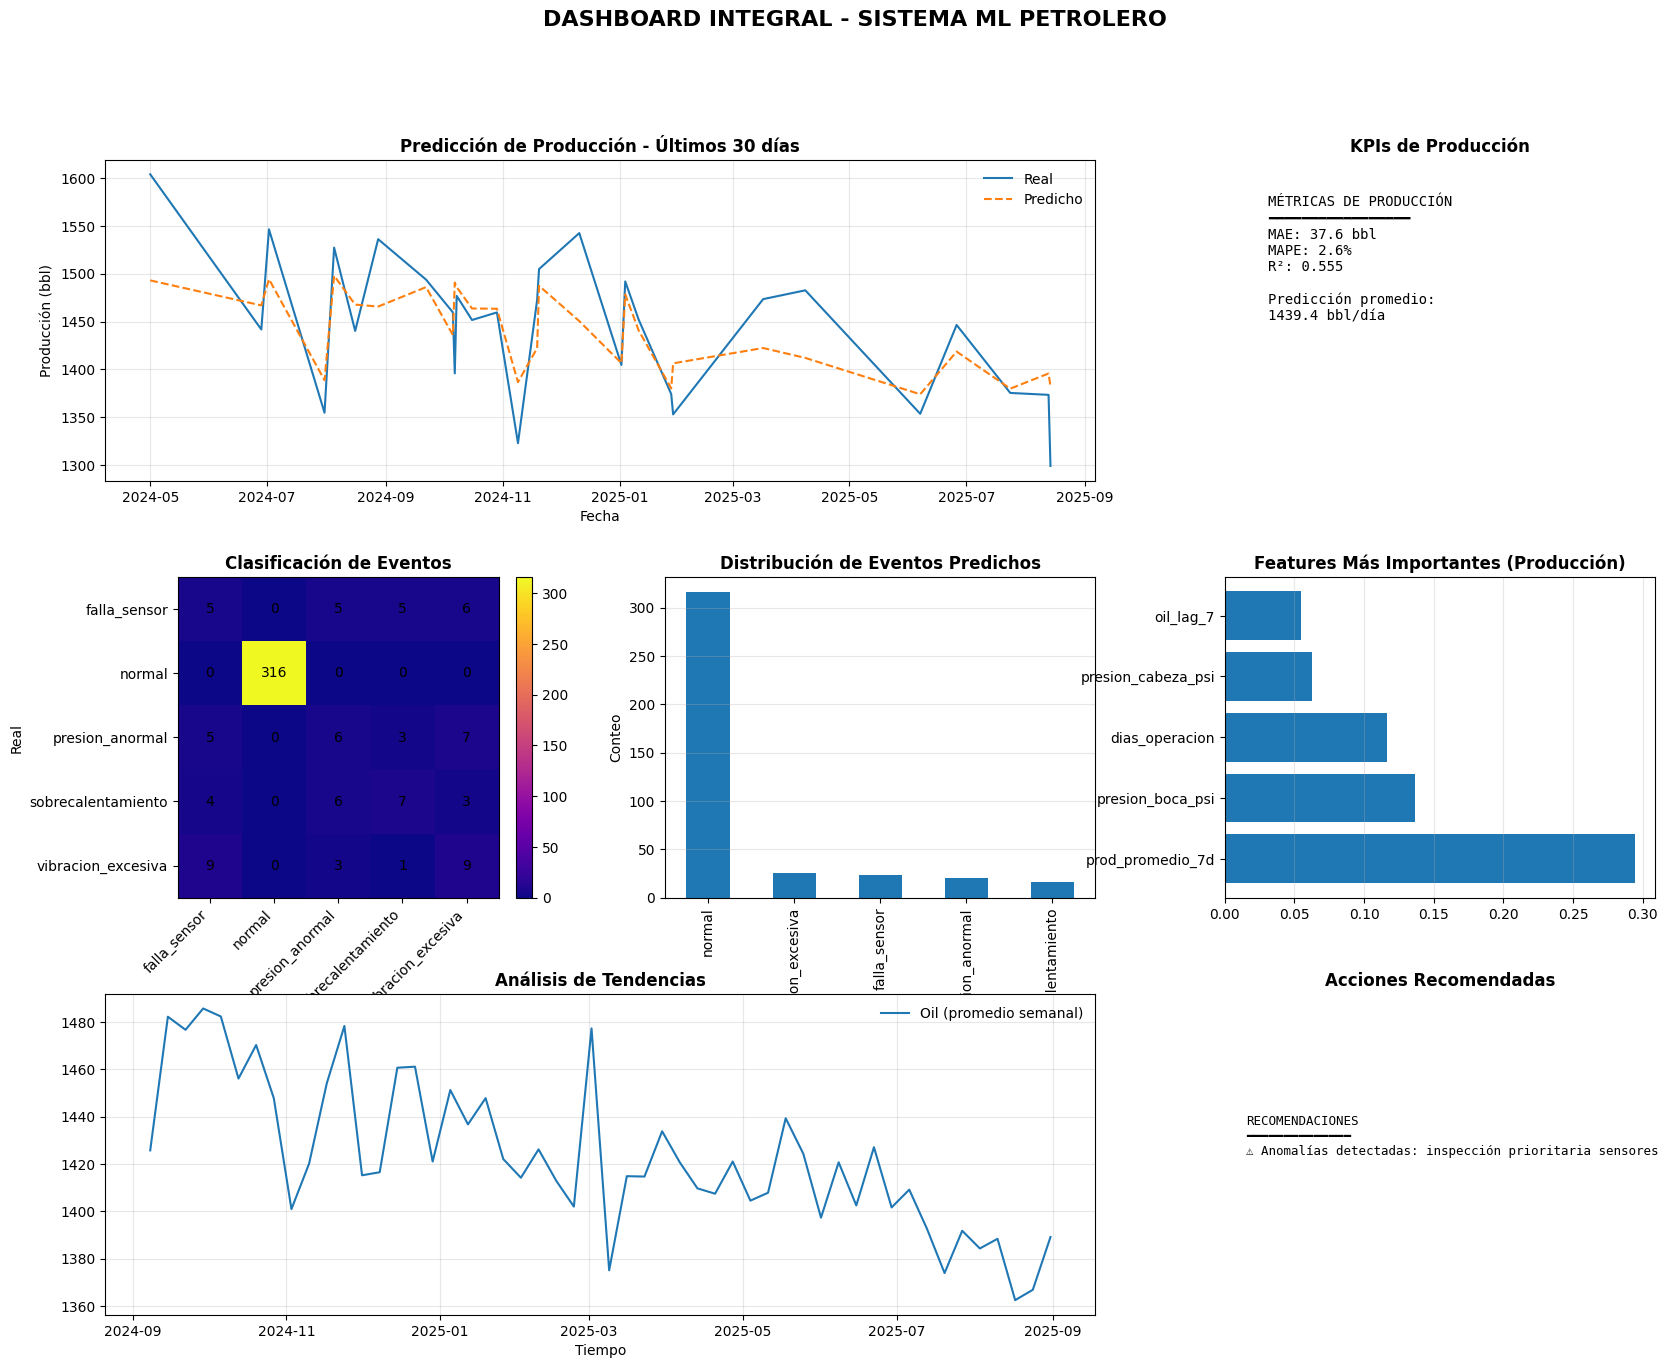

In [7]:
# TAREA 5: Dashboard de resultados
# =================================
print("\nTAREA 5: Crear dashboard de resultados")
print("-" * 40)

fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Panel 1: Predicción de producción (serie temporal) – últimos 30 días del último pozo
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_title('Predicción de Producción - Últimos 30 días', fontsize=12, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Producción (bbl)')
ax1.grid(True, alpha=0.3)

if 'X_prod_test' in locals():
    # Reconstruir un pequeño set temporal para graficar (toma el último pozo presente en test)
    sample_idx = df_prod.loc[X_prod_test.index, ['well_id', 'fecha', 'produccion_oil_bbl']].copy()
    sample_idx = sample_idx.sort_values('fecha').tail(30)

    y_hat_all = pipeline_produccion.predict(X_prod.loc[sample_idx.index])
    ax1.plot(sample_idx['fecha'], sample_idx['produccion_oil_bbl'], label='Real')
    ax1.plot(sample_idx['fecha'], y_hat_all, label='Predicho', linestyle='--')
    ax1.legend(frameon=False)

# Panel 2: Métricas de producción
ax2 = fig.add_subplot(gs[0, 2])
if 'X_prod_test' in locals():
    metricas_texto = f"""
MÉTRICAS DE PRODUCCIÓN
━━━━━━━━━━━━━━━━━
MAE: {mae:.1f} bbl
MAPE: {mape:.1f}%
R²: {r2:.3f}

Predicción promedio:
{np.mean(y_pred_prod):.1f} bbl/día
"""
else:
    metricas_texto = """
MÉTRICAS DE PRODUCCIÓN
━━━━━━━━━━━━━━━━━
MAE: N/A
MAPE: N/A
R²: N/A
"""
ax2.text(0.1, 0.5, metricas_texto.strip(), fontsize=10, family='monospace')
ax2.set_title('KPIs de Producción', fontsize=12, fontweight='bold')
ax2.axis('off')


# Panel 3: Matriz de confusión (conteos, estilo archivo resuelto)
ax3 = fig.add_subplot(gs[1, 0])
def plot_confusion_heatmap_counts(cm, classes, ax, title="Clasificación de Eventos"):
    import numpy as _np
    import matplotlib.pyplot as _plt
    im = ax.imshow(cm, interpolation="nearest", cmap="plasma")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    _plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plot_confusion_heatmap_counts(cm, classes, ax3, title="Clasificación de Eventos")

# Panel 4: Distribución de eventos predichos
ax4 = fig.add_subplot(gs[1, 1])
pd.Series(y_pred_evt).value_counts().plot(kind='bar', ax=ax4)
ax4.set_title('Distribución de Eventos Predichos', fontsize=12, fontweight='bold')
ax4.set_xlabel('Tipo de evento')
ax4.set_ylabel('Conteo')
ax4.grid(True, axis='y', alpha=0.3)

# Panel 5: Importancia de features
ax5 = fig.add_subplot(gs[1, 2])
try:
    importances = pipeline_produccion.named_steps['modelo'].feature_importances_
    idx_sorted = np.argsort(importances)[::-1][:5]
    top_feats = np.array(cols_disponibles)[idx_sorted]
    top_vals = importances[idx_sorted]
    ax5.barh(range(len(top_feats))[::-1], top_vals[::-1])
    ax5.set_yticks(range(len(top_feats))[::-1])
    ax5.set_yticklabels(top_feats[::-1])
    ax5.set_title('Features Más Importantes (Producción)', fontsize=12, fontweight='bold')
except Exception as e:
    ax5.text(0.1, 0.5, "No disponible", fontsize=12)
    ax5.set_title('Features Más Importantes', fontsize=12, fontweight='bold')
ax5.grid(True, axis='x', alpha=0.3)

# Panel 6: Análisis de tendencias
ax6 = fig.add_subplot(gs[2, :2])
ax6.set_title('Análisis de Tendencias', fontsize=12, fontweight='bold')
ax6.set_xlabel('Tiempo')
ax6.grid(True, alpha=0.3)
# Tendencia simple de producción real
if df_procesado is not None:
    serie = (
        df_procesado[['fecha', 'produccion_oil_bbl']]
        .dropna()
        .set_index('fecha')
        .resample('W')
        .mean()
        .tail(52)
    )
    ax6.plot(serie.index, serie['produccion_oil_bbl'], label='Oil (promedio semanal)')
    ax6.legend(frameon=False)

# Panel 7: Recomendaciones (placeholder, actualizado si hay señales)
ax7 = fig.add_subplot(gs[2, 2])
recomendaciones_txt = ["RECOMENDACIONES", "━━━━━━━━━━━━━━"]
if 'X_prod_test' in locals() and len(y_pred_prod) >= 7:
    tendencia = np.polyfit(range(7), y_pred_prod[-7:], 1)[0]
    if tendencia < -10:
        recomendaciones_txt.append("⚠ Caída de producción: revisar parámetros")
        recomendaciones_txt.append("→ Evaluar choke size y presión de cabeza")

# Señales de eventos críticos
criticos = {'falla_sensor', 'presion_anormal', 'vibracion_excesiva', 'sobrecalentamiento'}
if any(evt in criticos for evt in y_pred_evt[:50]):  # muestra
    recomendaciones_txt.append("⚠ Anomalías detectadas: inspección prioritaria sensores")

if len(recomendaciones_txt) == 2:
    recomendaciones_txt.append("✓ Operación estable. Mantener monitoreo.")

ax7.text(0.05, 0.5, "\n".join(recomendaciones_txt), fontsize=9, family='monospace')
ax7.set_title('Acciones Recomendadas', fontsize=12, fontweight='bold')
ax7.axis('off')

plt.suptitle('DASHBOARD INTEGRAL - SISTEMA ML PETROLERO', fontsize=16, fontweight='bold')
plt.savefig('Análisis Modelo Integral.png', dpi=110, bbox_inches='tight')
print("✓ Dashboard guardado como 'dashboard_ml_integral.png'")

In [8]:
# TAREA 6: Sistema de recomendaciones
# ====================================
print("\nTAREA 6: Sistema de recomendaciones automatizado")
print("-" * 40)

def generar_recomendaciones(predicciones_prod, predicciones_eventos, parametros_actuales):
    """
    Genera recomendaciones basadas en las predicciones

    Parámetros:
    -----------
    predicciones_prod : array
        Predicciones de producción
    predicciones_eventos : array
        Predicciones de eventos (tipos de anomalía)
    parametros_actuales : dict
        Parámetros operacionales actuales

    Retorna:
    --------
    list : Lista de recomendaciones priorizadas
    """
    recomendaciones = []

    # Analizar tendencia de producción
    if predicciones_prod is not None and len(predicciones_prod) >= 7:
        tendencia = np.polyfit(range(7), predicciones_prod[-7:], 1)[0]
        if tendencia < -10:  # Caída significativa
            recomendaciones.append({
                'prioridad': 'ALTA',
                'tipo': 'PRODUCCIÓN',
                'accion': 'Revisar parámetros operacionales',
                'impacto': f'Caída de {abs(tendencia):.1f} bbl/día detectada'
            })

    # Analizar eventos predichos
    eventos_criticos = {'falla_sensor', 'presion_anormal', 'vibracion_excesiva', 'sobrecalentamiento'}
    for evento in predicciones_eventos:
        if evento in eventos_criticos:
            recomendaciones.append({
                'prioridad': 'CRÍTICA',
                'tipo': 'MANTENIMIENTO',
                'accion': f'Intervención inmediata - {evento} detectado',
                'impacto': 'Prevenir parada no planificada'
            })

    # Optimización de parámetros (reglas simples)
    if parametros_actuales.get('presion_boca_psi', 0) < 1200:
        recomendaciones.append({
            'prioridad': 'MEDIA',
            'tipo': 'OPTIMIZACIÓN',
            'accion': 'Aumentar presión de boca',
            'impacto': 'Potencial aumento de 3-5% en producción'
        })

    return sorted(recomendaciones, key=lambda x: 
                 {'CRÍTICA': 0, 'ALTA': 1, 'MEDIA': 2}.get(x['prioridad'], 3))

# Probar el sistema de recomendaciones (demo)
parametros_ejemplo = {
    'presion_boca_psi': 1100,
    'temperatura_f': 185,
    'choke_size': 30
}

predicciones_prod_ejemplo = None
if 'X_prod_test' in locals():
    predicciones_prod_ejemplo = y_pred_prod

predicciones_eventos_ejemplo = y_pred_evt[:20] if 'y_pred_evt' in locals() else []

recomendaciones = generar_recomendaciones(
    predicciones_prod_ejemplo if predicciones_prod_ejemplo is not None else np.array([]),
    predicciones_eventos_ejemplo,
    parametros_ejemplo
)

print("\nRECOMENDACIONES GENERADAS:")
print("=" * 40)
for i, rec in enumerate(recomendaciones, 1):
    print(f"\n{i}. [{rec['prioridad']}] {rec['tipo']}")
    print(f"   Acción: {rec['accion']}")
    print(f"   Impacto: {rec['impacto']}")

# ANÁLISIS ROI
# ============
print("\n" + "=" * 55)
print("ANÁLISIS DE RETORNO DE INVERSIÓN (ROI)")
print("=" * 55)

def calcular_roi_ml(mejora_produccion_pct=5, reduccion_fallas_pct=30, 
                     costo_implementacion=50000):
    """
    Calcula el ROI de implementar el sistema ML
    """
    # Supuestos
    produccion_diaria_bbl = 1000
    precio_barril = 75
    dias_año = 365
    costo_falla_dia = 500000
    fallas_año_sin_ml = 6

    # Beneficios
    ganancia_produccion = (produccion_diaria_bbl * mejora_produccion_pct/100 * 
                          precio_barril * dias_año)

    fallas_evitadas = fallas_año_sin_ml * reduccion_fallas_pct/100
    ahorro_fallas = fallas_evitadas * costo_falla_dia

    beneficio_total = ganancia_produccion + ahorro_fallas

    # ROI
    roi = ((beneficio_total - costo_implementacion) / costo_implementacion) * 100
    payback_meses = (costo_implementacion / (beneficio_total / 12))

    print(f"Análisis ROI del Sistema ML:")
    print(f"  Inversión inicial: ${costo_implementacion:,}")
    print(f"  Ganancia por producción: ${ganancia_produccion:,.0f}/año")
    print(f"  Ahorro por prevención: ${ahorro_fallas:,.0f}/año")
    print(f"  Beneficio total anual: ${beneficio_total:,.0f}")
    print(f"  ROI: {roi:.1f}%")
    print(f"  Período de recuperación: {payback_meses:.1f} meses")

    return roi

# Calcular ROI
roi_sistema = calcular_roi_ml()


TAREA 6: Sistema de recomendaciones automatizado
----------------------------------------

RECOMENDACIONES GENERADAS:

1. [CRÍTICA] MANTENIMIENTO
   Acción: Intervención inmediata - sobrecalentamiento detectado
   Impacto: Prevenir parada no planificada

2. [CRÍTICA] MANTENIMIENTO
   Acción: Intervención inmediata - presion_anormal detectado
   Impacto: Prevenir parada no planificada

3. [CRÍTICA] MANTENIMIENTO
   Acción: Intervención inmediata - presion_anormal detectado
   Impacto: Prevenir parada no planificada

4. [MEDIA] OPTIMIZACIÓN
   Acción: Aumentar presión de boca
   Impacto: Potencial aumento de 3-5% en producción

ANÁLISIS DE RETORNO DE INVERSIÓN (ROI)
Análisis ROI del Sistema ML:
  Inversión inicial: $50,000
  Ganancia por producción: $1,368,750/año
  Ahorro por prevención: $900,000/año
  Beneficio total anual: $2,268,750
  ROI: 4437.5%
  Período de recuperación: 0.3 meses


In [9]:
# PREGUNTA DE REFLEXIÓN
# =====================
print("\n" + "=" * 55)
print("PREGUNTAS DE REFLEXIÓN FINAL:")
print("=" * 55)
print("""
Reflexiona sobre la implementación completa:

1. ¿Cuáles son los principales desafíos para implementar este sistema en producción?
2. ¿Qué datos adicionales mejorarían significativamente los modelos?
3. ¿Cómo asegurarías que el modelo se mantenga actualizado con el tiempo?
4. ¿Qué métricas de negocio usarías para medir el éxito del sistema?
5. ¿Cómo comunicarías el valor de este sistema a la gerencia?

Escribe tus respuestas como comentarios aquí:
""")



PREGUNTAS DE REFLEXIÓN FINAL:

Reflexiona sobre la implementación completa:

1. ¿Cuáles son los principales desafíos para implementar este sistema en producción?
2. ¿Qué datos adicionales mejorarían significativamente los modelos?
3. ¿Cómo asegurarías que el modelo se mantenga actualizado con el tiempo?
4. ¿Qué métricas de negocio usarías para medir el éxito del sistema?
5. ¿Cómo comunicarías el valor de este sistema a la gerencia?

Escribe tus respuestas como comentarios aquí:



1. Desafíos de implementación:
- Monitorización en producción
- Calidad y sincronía de datos
- Medición de valor

2. Datos adicionales valiosos:
- Presión de reservorio, presión capilar, saturación de fluidos.
- Permeabilidad y porosidad de la roca (mediciones core/logs).
- Información de contactos agua-gas-petróleo y su movimiento en el tiempo
- Tipo de completación (convencional, fractura, ESP, PCP).
- Registro de intervenciones y cambios de equipo.
- Estado actual del sistema artificial de levantamiento.

3. Mantenimiento del modelo:
- Monitorización continua (datos + modelo)
- Estrategia de re-entrenamiento

4. Métricas de éxito:
- Incremento neto de producción (bbl/día)
- Barriles adicionales recuperados por año
- Valor económico de la producción incremental
- Reducción de fallas no planificadas (%)

5. Comunicación de valor:
- Enfoque en resultados financieros
- KPI´s
- Riesgo y confiabilidad


 
 

In [10]:
print("\n" + "=" * 55)
print("¡FELICITACIONES! Has completado la Sesión 16")
print("=" * 55)
print("""
Has aprendido a:
✓ Preparar datos para Machine Learning
✓ Implementar modelos de regresión y clasificación
✓ Evaluar modelos con métricas apropiadas
✓ Crear sistemas de detección de anomalías
✓ Desarrollar pipelines integrales de ML
✓ Generar recomendaciones automatizadas
✓ Calcular el ROI de soluciones ML

Próximos pasos sugeridos:
→ Explorar modelos más avanzados (XGBoost, redes neuronales)
→ Implementar validación temporal para series de tiempo
→ Desarrollar APIs para servir los modelos
→ Crear pipelines de reentrenamiento automático
""")


¡FELICITACIONES! Has completado la Sesión 16

Has aprendido a:
✓ Preparar datos para Machine Learning
✓ Implementar modelos de regresión y clasificación
✓ Evaluar modelos con métricas apropiadas
✓ Crear sistemas de detección de anomalías
✓ Desarrollar pipelines integrales de ML
✓ Generar recomendaciones automatizadas
✓ Calcular el ROI de soluciones ML

Próximos pasos sugeridos:
→ Explorar modelos más avanzados (XGBoost, redes neuronales)
→ Implementar validación temporal para series de tiempo
→ Desarrollar APIs para servir los modelos
→ Crear pipelines de reentrenamiento automático

